<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/operanalyst/simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quite Complex Simulation

### Inevitable Imports

In [187]:
!pip install pyproj

In [0]:
import scipy.integrate as integrate # for numerical solution od differential equations
import matplotlib.pyplot as plt     # for plots
import pandas as pd                 # for tables
import numpy as np                  # for matrices
import math as math

import folium
from pyproj import Proj

simulatedObjects = []

### Display functions 

,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


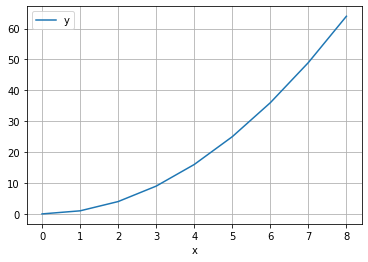

In [189]:
def displayData(data):
  display(pd.DataFrame(data))

def plotData(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  newax = None
  if ax is None:
    newax = df.plot.line(x = x, y = y)
  else:
    newax = df.plot.line(x = x, y = y, ax = ax)
  return newax

#=================#
# example of use  #
#=================#
#data = [(0, 0), (1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (6, 36), (7, 49)]
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
plotData(data)
plt.grid(which='both')
displayData(data)

### Operators on Data Streams

In [190]:
def skipo(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    try:
        next(innerGen)
    except StopIteration:
        pass
  return innerGen

def skip(generator, count):
  innerGen = iter(generator)
  i = count
  if i == 0:
    return innerGen
  for item in innerGen:
    i = i - 1
    if i == 0:
      break
  return innerGen

def take(generator, count):
  innerGen = iter(generator)
  i = count
  for item in innerGen:
    if i == 0:
      break
    yield item
    i = i - 1
  return innerGen


def take0(generator, count):
  innerGen = iter(generator)
  for index in range(count):
    try:
        yield next(innerGen)
    except StopIteration:
        pass
  

def dilute(generator, ratio):
  innerGen = iter(generator)
  while True:
    innerGen = skip(innerGen, ratio - 1)
    try:
        yield next(innerGen)
    except StopIteration:
        break

#=================#
# example of use  #
#=================#
data = [
  {'x': 0, 'y': 0}, {'x': 1, 'y': 1}, {'x': 2, 'y': 4},
  {'x': 3, 'y': 9}, {'x': 4, 'y': 16}, {'x': 5, 'y': 25},
  {'x': 6, 'y': 36}, {'x': 7, 'y': 49}, {'x': 8, 'y': 64},
]
partOfData = take(skip(data, 5), 2) # skip five, take two next, rest blow up
dilutedData = dilute(data, 2) # every odd
displayData(data)
displayData(partOfData)
displayData(dilutedData)


,x,y
0,0,0
1,1,1
2,2,4
3,3,9
4,4,16
5,5,25
6,6,36
7,7,49
8,8,64


,x,y
0,5,25
1,6,36


,x,y
0,1,1
1,3,9
2,5,25
3,7,49


### Some Theory 
$\left( y=f(x)  \right)$

### Compute One Step function

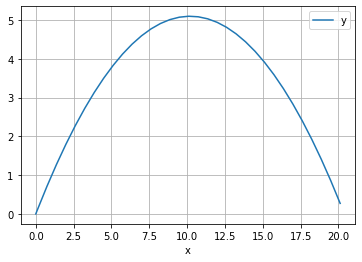

In [191]:
def compute(model, state0, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  solver = integrate.RK45(fun = model, t0 = t0, y0 = state0, t_bound = t_bound, max_step = max_step)

  while True:
    message = solver.step()
    currentItem = {'time': solver.t, 'y': [*solver.y], 'yd': [*model(solver.t, solver.y)]}

    yield currentItem # send signal, inform about current result
    if (not(solver.status == 'running')):
        break
  return

#=================#
# example of use  #
#=================#
def model2D(time, state):
  velocity = state[:2]
  position = state[2:]
  acceleration = [0, -9.81]
  return [*acceleration, *velocity]

sim = compute(model2D, [10, 10, 0, 0])
result = []
for index, state in enumerate(sim):
  result.append(state)
  if index == 34: #magic number
    break

xy = list(map(lambda item: {'x': item['y'][2], 'y': item['y'][3]}, result))
plotData(xy)
plt.grid(which='both')

### Prepare and Simulate

In [0]:
def prepareSimulation(systemList, t0 = 0.0, t_bound = 10, max_step = 0.0625):
  for system in systemList:
    system['solver'] = compute(system['model'], system['state0'], t0 = t0, t_bound = t_bound, max_step = max_step)
    system['finished'] = False
    system['result'] = next(system['solver'])#system['state0']

def simulate(systemList):
  for system in systemList:
    if system['finished'] == False:
      system['result'] = next(system['solver'])

### Nearly Infinite Simulation

In [0]:
def simulateInf(systemList, count = -1):
  cc = count
  while True:
    simulate(systemList)
    partialResult = {}
    for system in systemList:
      partialResult[system['name']] = {**system}
    yield partialResult
    cc = cc - 1
    if cc == 0:
      break # maximum steps reached, break it


### Example of Single System Simulation

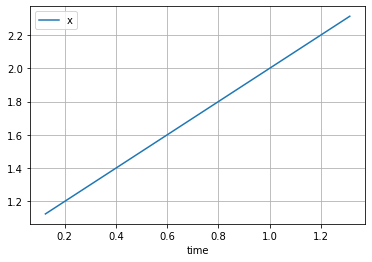

In [194]:
def movingObj(time, state):
  velocity = state[:3]
  position = state[3:]
  acceleration = [0, 0, 0]
  return [*acceleration, *velocity]

def rearangeResults(results, selectors):
  for result in results:
    partialResult = {}
    for selector in selectors:
      partialResult[selector['name']] = selector['selector'](result)
    yield partialResult

simulatedObjects = [{'state0': [1, 0.75, 0, 1, 1, 0], 'model': movingObj, 'name': 'obj1'}]
prepareSimulation(simulatedObjects)
simResults = list(simulateInf(simulatedObjects, 20))
simResultsRearanged = list(rearangeResults(simResults, 
  [
   {'name': 'time', 'selector': lambda item: item['obj1']['result']['time']},
   {'name': 'x', 'selector': lambda item: item['obj1']['result']['y'][3]},
   {'name': 'y', 'selector': lambda item: item['obj1']['result']['y'][4]}
   ]))

#simResults = list(justTwoFromResults(simResults, 'obj1', x = 3, y = 4))
#displayData(simResultsRearanged)
plotData(simResultsRearanged)#, x = 'x', y = 'y')
plt.grid(which='both')

### More Complex Simulation

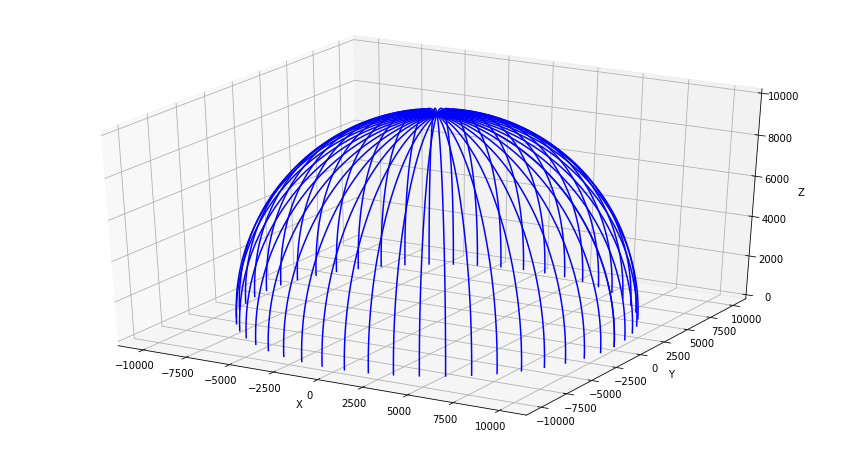

In [195]:
from math import pi, sin, cos

def angles(start, end, count = 50):
  delta = (end - start) / count
  for i in range(count + 1):
    yield start + i * delta

def segment(alpha, radius):
  for beta in angles(0, pi / 2):
    result = {
        'x': radius * cos(alpha) * cos(beta), 
        'y': radius * sin(alpha) * cos(beta),
        'z': radius * sin(beta),
        }
    #print(result)
    yield result

radius = 10000
gph = plt.figure(figsize=(15,8)).gca(projection='3d')
for alpha in angles(0, 2 * pi):
  s = list(segment(alpha, radius))
  x = list(map(lambda item: item['x'], s))
  y = list(map(lambda item: item['y'], s))
  z = list(map(lambda item: item['z'], s))
  gph.plot(x, y, z, "b-")
  #break

gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()


## Complex Simulation
Simulation where the number of dynamic system is greater than 1.

### State Decomposer
Splits main state e.g. state of whole simulation into states of individual systems.

In [0]:
def decomposeState(state, state0List):
  result = []
  start = 0
  for state0 in state0List:
    end = start + len(state0)
    subState = state[start:end]
    result.append(subState)
    start = end
  return result

### Complex Model
Allows to create one model from set of models.

In [0]:
def complexModel(t, state, modelList, state0List):
  dstate = []
  for model, subState in zip(modelList, decomposeState(state, state0List)):
    dsubstate = model(t, subState)
    dstate = dstate + dsubstate
  return dstate

### Complex Solver
Yields timeline of result which are already decomposed into subsystem results.

In [0]:
def computeComplex(modelList, state0List, t0 = 0.0, t_bound = 10, max_step = 0.0625):

  complexm = lambda t, state: complexModel(t, state, modelList, state0List)
  complexstate0 = []
  for state0 in state0List:
    complexstate0 = complexstate0 + state0

  solver = integrate.RK45(fun = complexm, t0 = t0, y0 = complexstate0, t_bound = t_bound, max_step = max_step)
  while True:
    message = solver.step()

    complexResult = {}
    complexResult['time'] = solver.t
    complexResult['y'] = decomposeState(solver.y, state0List)
    complexResult['dy'] = decomposeState(complexm(solver.t, solver.y), state0List)

    yield complexResult # send signal, inform about current result
    if (not(solver.status == 'running')):
        break
  return

### Example of Use
Lets have two systems and simulate them simultaneously.

In [199]:
def systemA(t, state):
  return [0, 0, 0, *state[:3]] # nezrychlujici, tj. konstantni rychlost
def systemB(t, state):
  return [0, 0, -9.81, *state[:3]] # pohyb v gravitacnim poli

systemA0 = [100, 0, 0, 0, 0, 1000]
systemB0 = [100, 0, 150, 0, 0, 0]

ge = computeComplex([systemA, systemB], [systemA0, systemB0])
data = list(take(ge, 10))
displayData(data)

,time,y,dy
0,0.000010,"[[100.0, 0.0, 0.0, 0.0009701357900590773, 0.0,...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
1,0.000107,"[[100.0, 0.0, 0.0, 0.010671493690649852, 0.0, ...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
2,0.001077,"[[100.0, 0.0, 0.0, 0.10768507269655758, 0.0, 1...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
3,0.010778,"[[100.0, 0.0, 0.0, 1.077820862755635, 0.0, 100...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
4,0.073278,"[[100.0, 0.0, 0.0, 7.327820862755635, 0.0, 100...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
5,0.135778,"[[100.0, 0.0, 0.0, 13.577820862755635, 0.0, 10...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
6,0.198278,"[[100.0, 0.0, 0.0, 19.827820862755637, 0.0, 10...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
7,0.260778,"[[100.0, 0.0, 0.0, 26.077820862755637, 0.0, 10...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
8,0.323278,"[[100.0, 0.0, 0.0, 32.32782086275564, 0.0, 100...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."
9,0.385778,"[[100.0, 0.0, 0.0, 38.57782086275564, 0.0, 100...","[[0, 0, 0, 100.0, 0.0, 0.0], [0, 0, -9.81, 100..."


,time,system0_x,system0_z,system0_vx,system0_vz,system1_x,system1_z,system1_vx,system1_vz
0,0.000010,0.000970,1000.0,100.0,0.0,0.000970,0.001455,100.0,149.999905
1,0.000107,0.010671,1000.0,100.0,0.0,0.010671,0.016007,100.0,149.998953
2,0.001077,0.107685,1000.0,100.0,0.0,0.107685,0.161522,100.0,149.989436
3,0.010778,1.077821,1000.0,100.0,0.0,1.077821,1.616161,100.0,149.894266
4,0.073278,7.327821,1000.0,100.0,0.0,7.327821,10.965393,100.0,149.281141
...,...,...,...,...,...,...,...,...,...
158,9.698278,969.827821,1000.0,100.0,0.0,969.827821,993.394107,100.0,54.859891
159,9.760778,976.077821,1000.0,100.0,0.0,976.077821,996.803690,100.0,54.246766
160,9.823278,982.327821,1000.0,100.0,0.0,982.327821,1000.174953,100.0,53.633641
161,9.885778,988.577821,1000.0,100.0,0.0,988.577821,1003.507895,100.0,53.020516


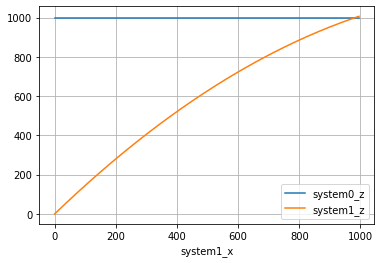

In [200]:
#def mapresults(resultsource, mapdic):
#  for item in resultsource:
#    cresult = {}
#    for key, value in mapdic.items():
#      cresult[key] = value(item)
#    yield cresult

def extractArrays(resultsource, mapdic):
  allResults = {}
  resultsource = list(resultsource)
  for key, value in mapdic.items():
    singleResult = list(map(value, resultsource))
    allResults[key] = singleResult
  return allResults

mapdic = {
    'time': lambda r: r['time'],
    'system0_x': lambda r: r['y'][0][3],
    'system0_z': lambda r: r['y'][0][5],
    'system0_vx': lambda r: r['y'][0][0],
    'system0_vz': lambda r: r['y'][0][1],
    'system1_x': lambda r: r['y'][1][3],
    'system1_z': lambda r: r['y'][1][5],
    'system1_vx': lambda r: r['y'][1][0],
    'system1_vz': lambda r: r['y'][1][2],
    }

ge = computeComplex([systemA, systemB], [systemA0, systemB0])
resultData = list(take(ge, 163))
arrays = extractArrays(resultData, mapdic)

displayData(arrays)   
ax = plotData(arrays, x = 'system0_x', y = 'system0_z')
ax = plotData(arrays, x = 'system1_x', y = 'system1_z', ax = ax)
plt.grid(which='both')

## More Complex Simulation II

### Description


#### Plane Model

In [0]:
def createPlaneModel(input, planeSystem):
  def planeModel(time, state):
    if planeSystem()['destroyed']:
      return [0, 0, 0, 0, 0, 0]
    currentInput = input()
    
    currentVelocity = np.array(state[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector
    
    currentPosition = np.array(state[3:])
    targetPosition = np.array(currentInput)

    wantedVelocity = targetPosition - currentPosition
    wantedVelocityAbs = np.linalg.norm(wantedVelocity) # abs of vector
    wantedVelocity = wantedVelocity * currentVelocityAbs / wantedVelocityAbs

    omegaOneVector = np.cross(currentVelocity / currentVelocityAbs, wantedVelocity / wantedVelocityAbs)
    accOneVector = np.cross(omegaOneVector, currentVelocity / currentVelocityAbs)

    neededAcceleration = wantedVelocity - currentVelocity
    neededAccelerationAbs = np.linalg.norm(neededAcceleration)
    neededAccelerationAbs = 3 * neededAccelerationAbs * currentVelocityAbs / wantedVelocityAbs

    neededAcceleration = neededAccelerationAbs * neededAcceleration

    result = [*neededAcceleration, *currentVelocity]
    return result
  return planeModel

#### Rocket Model

|symbol|meaning|
|-|-|
|$\vec r_r$ | missile to target destination |
|$\vec v_r$ | missile to target velocity |
| $n$ | control gain (3-5)|
|$\vec v_m$| absolute velocity of missile |


vector form of $\omega = \frac {v}{r}$

$\vec \omega = \frac {\vec r_r \times \vec v_r }{ \vec r_r \cdot \vec r_r }$

$\vec a = -n|\vec v_r|\frac{\vec v_m}{|\vec v_m|} \times \vec \omega$

centripetal acceleration $a=\omega \cdot v$ vector form $\vec a = -\vec v \times \vec \omega $

In [0]:
def createRocketModel(rocketSystem, systemToDestroy, n = 3):

  def rocketModel(time, state):
    if rocketSystem()['destroyed']:
      return [0, 0, 0, 0, 0, 0]

    currentInput = systemToDestroy()['state']

    currentPosition = np.array(state[3:])
    currentVelocity = np.array(state[:3])

    targetPosition = np.array(currentInput[3:])
    targetVelocity  = np.array(currentInput[:3])
    currentVelocityAbs = np.linalg.norm(currentVelocity) # abs of vector

    positionR = targetPosition - currentPosition
    positionRAbs = np.linalg.norm(positionR) # abs of vector
    velocityR = targetVelocity - currentVelocity
    velocityRAbs = np.linalg.norm(velocityR) # abs of vector

    omega = 1 / positionRAbs / positionRAbs * np.cross(positionR, velocityR)

    neededAcceleration = -n * velocityRAbs / currentVelocityAbs * \
      np.cross(currentVelocity, omega)
    result = [*neededAcceleration, *currentVelocity]

    if positionRAbs < 1e0: # too close to target, eg. target hit
      #print('target', localData['target']())
      #print('rocket', localData['rocket']())
      #print('state', state)
      #print('currentInput', currentInput)
      rocketSystem()['destroyed'] = True
      systemToDestroy()['destroyed'] = True
    #'''
    return result
  return rocketModel

### Definition and Execution

,time,plane_x,plane_y,plane_z,plane_v,rocket_x,rocket_y,rocket_z,rocket_v
0,0.003989,4.310000e+06,2.198000e+06,1000.000000,99.990906,4.334999e+06,2.203800e+06,0.000004,223.606798
1,0.043876,4.310004e+06,2.198000e+06,1000.000000,99.900103,4.334991e+06,2.203796e+06,0.000433,223.606798
2,0.106376,4.310011e+06,2.198000e+06,999.999999,99.758333,4.334979e+06,2.203789e+06,0.002545,223.606798
3,0.168876,4.310017e+06,2.198000e+06,999.999996,99.617182,4.334966e+06,2.203783e+06,0.006412,223.606798
4,0.231376,4.310023e+06,2.198000e+06,999.999993,99.476646,4.334954e+06,2.203777e+06,0.012031,223.606798
...,...,...,...,...,...,...,...,...,...
1995,124.092879,4.315601e+06,2.197273e+06,999.669004,45.008248,4.315602e+06,2.197273e+06,999.572455,215.339489
1996,124.155379,4.315601e+06,2.197273e+06,999.669004,45.008248,4.315602e+06,2.197273e+06,999.572455,215.339489
1997,124.217879,4.315601e+06,2.197273e+06,999.669004,45.008248,4.315602e+06,2.197273e+06,999.572455,215.339489
1998,124.280379,4.315601e+06,2.197273e+06,999.669004,45.008248,4.315602e+06,2.197273e+06,999.572455,215.339489


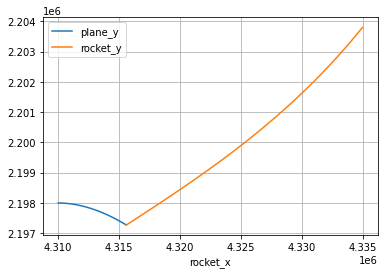

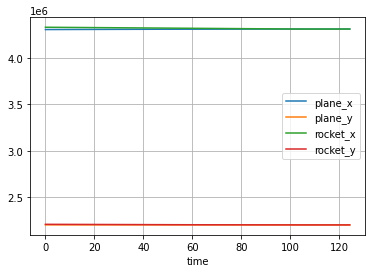

In [203]:
planeTarget = createFixedTarget(400, 400, 0)
plane = createPlaneModel(planeTarget, planeSystem = lambda : simulatedObjects[0])
rocket = createRocketModel(
    rocketSystem = lambda : simulatedObjects[1],
    systemToDestroy = lambda : simulatedObjects[0])

simulatedObjects = [
  {'state': [100, 0, 0, 4310000, 2198000, 1000], 'model': plane, 'name': 'plane', 'destroyed': False},
  {'state': [-200, -100, 0, 4335000, 2203800, 0], 'model': rocket, 'name': 'rocket', 'destroyed': False},
  ]

def feedback(simulatedObjects):
  def inner(resultStream):
    for result in resultStream:
      for obj, state in zip(simulatedObjects, result['y']):
        obj['state'] = state
      yield result
  return inner

mapdic = {
    'time': lambda r: r['time'],
    'plane_x': lambda r: r['y'][0][3],
    'plane_y': lambda r: r['y'][0][4],
    'plane_z': lambda r: r['y'][0][5],
#    'plane_vx': lambda r: r['y'][0][0],
#    'plane_vz': lambda r: r['y'][0][1],

    'plane_v': lambda r: sqrt(
      r['y'][0][0] * r['y'][0][0] +
      r['y'][0][1] * r['y'][0][1] +
      r['y'][0][2] * r['y'][0][2]),

    'rocket_x': lambda r: r['y'][1][3],
    'rocket_y': lambda r: r['y'][1][4],
    'rocket_z': lambda r: r['y'][1][5],
#    'rocket_vx': lambda r: r['y'][1][0],
#    'rocket_vz': lambda r: r['y'][1][2],

    'rocket_v': lambda r: sqrt(
      r['y'][1][0] * r['y'][1][0] +
      r['y'][1][1] * r['y'][1][1] +
      r['y'][1][2] * r['y'][1][2]),

    }  

modelList = list(map(lambda item: item['model'], simulatedObjects))
state0List = list(map(lambda item: item['state'], simulatedObjects))

saveProc = feedback(simulatedObjects)

ge = saveProc(computeComplex(modelList, state0List, t0 = 0.0, t_bound = 2000, max_step = 0.0625))
resultData = list(take(ge, 2000))
arrays = extractArrays(resultData, mapdic)
displayData(arrays) 

ax = plotData(arrays, x = 'plane_x', y = 'plane_y')
ax = plotData(arrays, x = 'rocket_x', y = 'rocket_y', ax = ax)
plt.grid(which='both')    

ax = plotData(arrays, x = 'time', y = 'plane_x')
ax = plotData(arrays, x = 'time', y = 'plane_y', ax = ax)
ax = plotData(arrays, x = 'time', y = 'rocket_x', ax = ax)
ax = plotData(arrays, x = 'time', y = 'rocket_y', ax = ax)
plt.grid(which='both')    

### 3D Plot

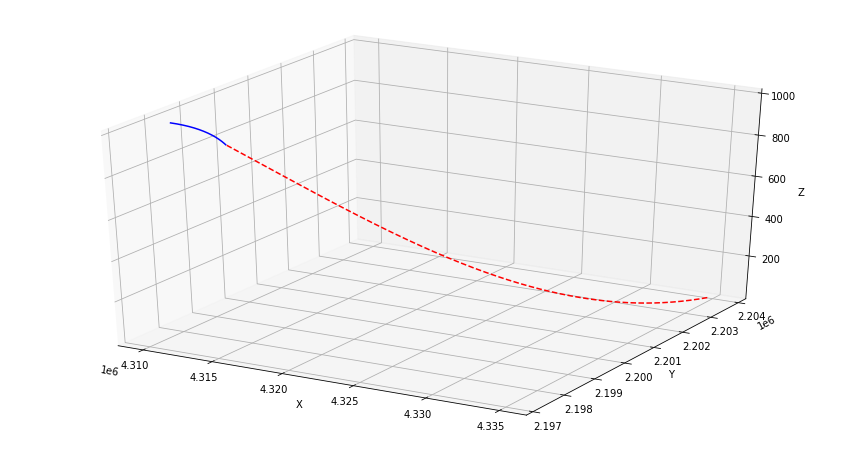

In [204]:
gph = plt.figure(figsize=(15,8)).gca(projection='3d')
#plotting red dotted lines with tiny markers
gph.plot(arrays['plane_x'], arrays['plane_y'], arrays['plane_z'], "b-")
gph.plot(arrays['rocket_x'], arrays['rocket_y'], arrays['rocket_z'], "r--")
gph.set_xlabel('X')
gph.set_ylabel('Y')
gph.set_zlabel('Z')

plt.show()

### Map Plot

In [205]:
!pip install pyproj

#### Map Preparation

In [0]:
def prepareMap(location=[49.1687516,16.6725822], zoom = 12):
  m = folium.Map(
      location=location,
      zoom_start=zoom,
  #    tiles='Stamen Terrain'
  )

  urlhead = 'http://services.arcgisonline.com/arcgis/rest/services'
  urltail = '/MapServer/tile/{z}/{y}/{x}'
  maps = {
  #  'World_Ocean_Base': '/Ocean/World_Ocean_Base',
  #  'World_Navigation_Charts': '/Specialty/World_Navigation_Charts',
  #  'World_Ocean_Reference': '/Ocean/World_Ocean_Reference',
  #  'NatGeo_World_Map': '/NatGeo_World_Map/MapServer',
    'World_Imagery': '/World_Imagery/MapServer',
  #  'World_Physical_Map': '/World_Physical_Map/MapServer',
    'World_Shaded_Relief': '/World_Shaded_Relief/MapServer',
    'World_Street_Map': '/World_Street_Map/MapServer',
  #  'World_Terrain_Base': '/World_Terrain_Base/MapServer',
    'World_Topo_Map': '/World_Topo_Map/MapServer'
  }

  for tile_name, tile_url in maps.items():
    wl = folium.WmsTileLayer(url = urlhead + tile_url + urltail, name = tile_name, show = False)
    wl.add_to(m)


  folium.LayerControl().add_to(m)
  fs = folium.plugins.Fullscreen()
  m.add_child(fs)
  return m

In [207]:
Wgs84Bl = Proj("+proj=utm +zone=33, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

planepath = []
for x, y in zip(arrays['plane_x'], arrays['plane_y']):
    coords = Wgs84Bl(x, y, inverse=True)
    planepath.append([coords[0], coords[1]])

rocketpath = []
for x, y in zip(arrays['rocket_x'], arrays['rocket_y']):
    coords = Wgs84Bl(x, y, inverse=True)
    rocketpath.append([coords[0], coords[1]])

m = prepareMap(location=[49.05, 16.6725822], zoom = 11)

folium.PolyLine(locations = rocketpath, color="red", weight=2.5, opacity=0.8, popup = 'Rocket', tooltip = tooltip).add_to(m)
folium.PolyLine(locations = planepath, color="blue", weight=2.5, opacity=0.8, popup = 'Plane', tooltip = tooltip).add_to(m)

m